# Classification model
## Adult Data Set
#### Abstract: 
Predict whether income exceeds $50K/yr based on US census data. Also known as "Census Income" dataset. 

https://archive.ics.uci.edu/ml/datasets/adult


In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import math
import matplotlib.pyplot as plt 

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, LassoCV
    
#from imblearn.over_sampling import SMOTE

%matplotlib inline
# ignore all warnings
import warnings
warnings.simplefilter("ignore")

The relevant data exploration process (pre-processing, feature extraction/selection, clustering
and visualization) 
1. treatment of lost values (missing values)
2. treatment of anomalous values (outliers)
3. treatment of incoherent or incorrect values
4. coding of non-continuous or non-ordered variables (nominal or binary)
5. possible elimination of irrelevant or redundant variables (feature selection)
6. creation of new variables that can be useful (feature extraction)
7. normalization of the variables (e.g. standardization)
8. transformation of the variables (e.g. correction of serious skewness and/or kurtosis)

In [2]:
def distributionPlot(data, columnNumber):
    """ 
    Generates the distribution plot for the given data.

    Parameters:
        data: dataframe with the data to plot.
        columNumber: Number of columns the plot will return.

    """
    data_columns = data.columns.values
    #data_columns = data._get_numeric_data().columns.values
    plot_columns = columnNumber
    number_of_columns = math.ceil(len(data_columns)/plot_columns)
    number_of_rows = math.ceil((len(data_columns))/number_of_columns)

    plt.figure(figsize=(16,22))

    # plot distribution
    for i in range(0, len(data_columns)):
        plt.subplot(number_of_columns + 1, number_of_rows, i+1)
        sns.distplot(data[data_columns[i]], kde=True) 

In [31]:
df_train = pd.read_csv('adult_train.csv')
df_test = pd.read_csv('adult_test.csv')
df_train.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educationNum',
       'maritalStatus', 'occupation', 'relationship', 'race', 'sex',
       'capitalGain', 'capitalLoss', 'hoursWeek', 'nativeCountry', 'target'],
      dtype='object')

# Data Transformation

## Treatment of lost values (missing values)

Out testing dataset doesn't have missing values but on further inspection the unknown values have been replaced with a " ?" when there's a missing value. So we are going to use pandas replace_to para reemplazarlo con NaN y que podamos hacer algo con esos values. https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html

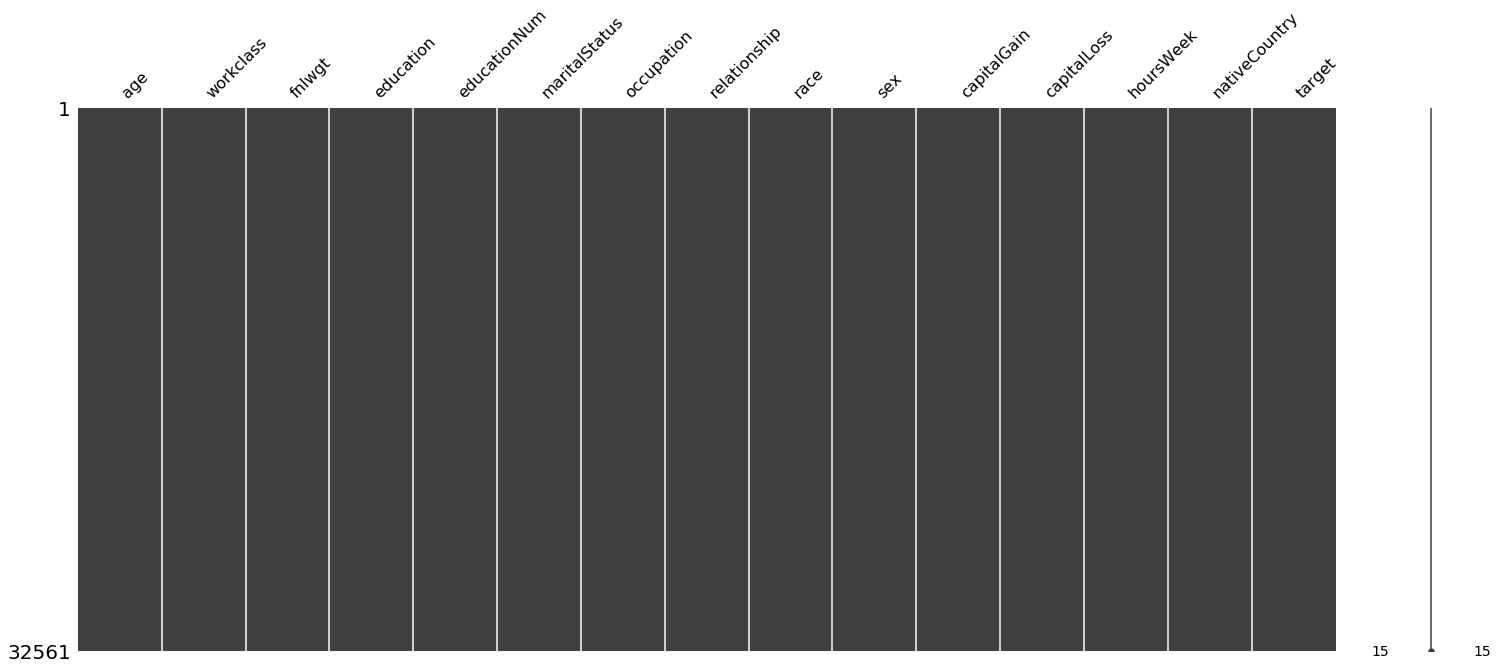

In [4]:
msno.matrix(df_train)

In [32]:
df_train = df_train.replace(' ?', np.nan)

In [41]:
#df_train['workclass'][61] - test de uno que era ' ?' antes de convertir

nan

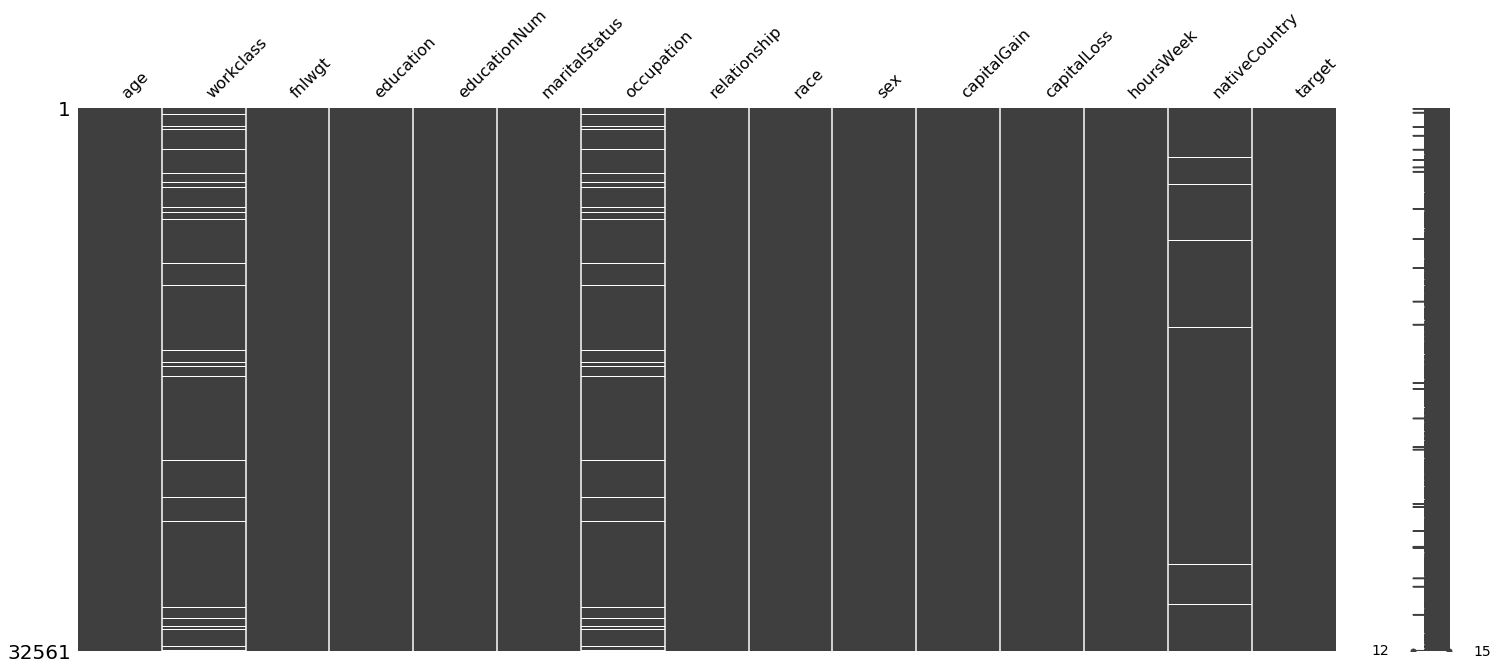

In [6]:
msno.matrix(df_train)

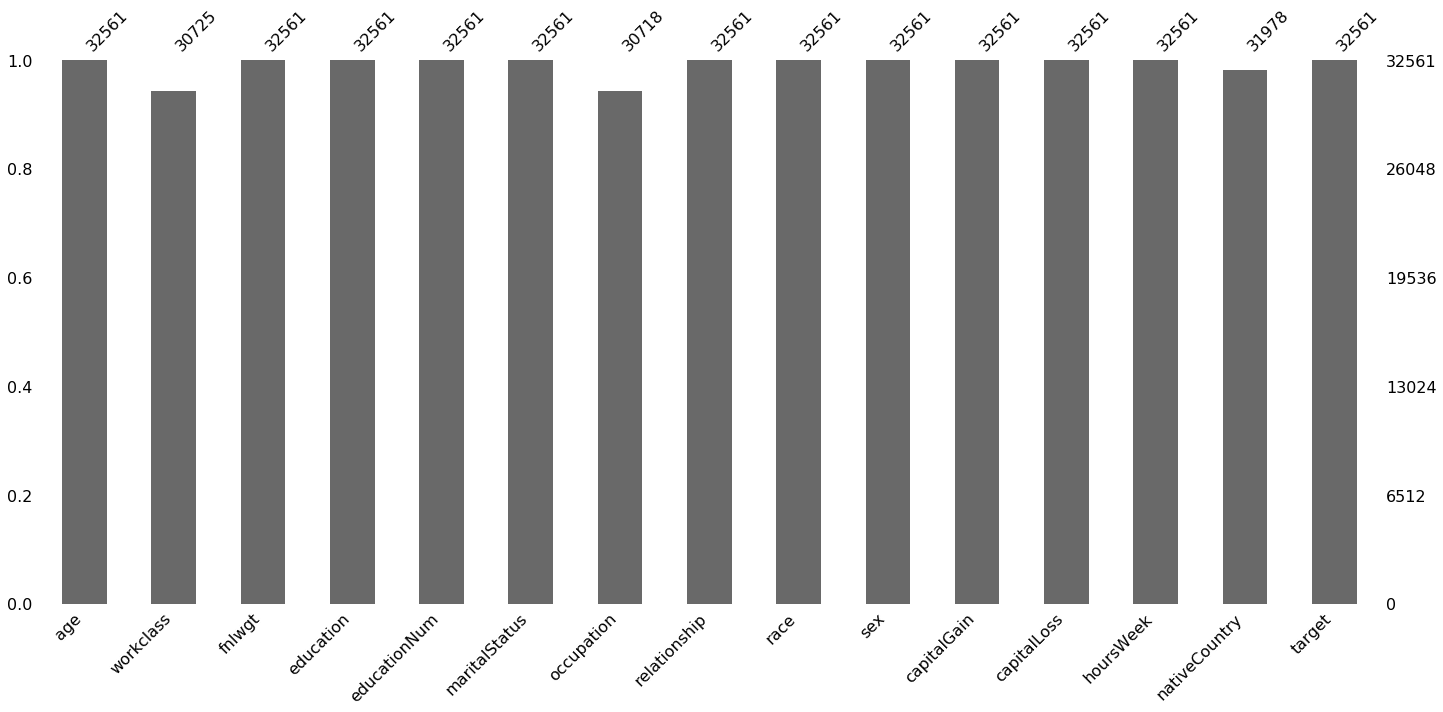

In [7]:
msno.bar(df_train)

In [33]:
df_train.isnull().sum()

age                 0
workclass        1836
fnlwgt              0
education           0
educationNum        0
maritalStatus       0
occupation       1843
relationship        0
race                0
sex                 0
capitalGain         0
capitalLoss         0
hoursWeek           0
nativeCountry     583
target              0
dtype: int64

As we can observe workclass, occupation and native-country features contain missing values 1836, 1843 and 583 values to be exact.

* Workclass and occupation are both considerably important features if we want to predict is someone earns more than 50k

* Native-country is the most delicate feature, due to changing with the median will affect to the dataset. We will try to infer the best age by grouo or class.

In [34]:
#Drops rows with NaN values
df_train = df_train.dropna()
df_train = df_train.reset_index(drop=True)

In [35]:
df_train.isnull().sum()

age              0
workclass        0
fnlwgt           0
education        0
educationNum     0
maritalStatus    0
occupation       0
relationship     0
race             0
sex              0
capitalGain      0
capitalLoss      0
hoursWeek        0
nativeCountry    0
target           0
dtype: int64

In [36]:
df_train = df_train.drop(['fnlwgt'], axis=1)

## Data skewness


Before moving on to converting the categorical features, we're going to deal with the skewness and outliers from the numeric features:

As we can observe in the above distribution graphs the majority of the features are far from the normal distribution. Moreover, we can observe that some of the features have positive skewness (right) and there is not any negative skewness (left). In orther to achieve a normal distribution in these features we will use the next transformations:
* **Positive skewed features**:
       - Square root tranformation
       - Cube root transformation
       - Log transformation
* **Negative skewed features**:
        - Square transformation
        - Cube transformation

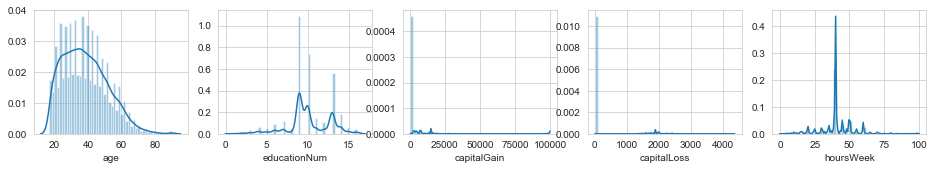

In [37]:
data_columns = df_train._get_numeric_data().columns.values
plot_columns = 7
number_of_columns = math.ceil(len(data_columns)/plot_columns)
number_of_rows = math.ceil((len(data_columns))/number_of_columns)

plt.figure(figsize=(16,5))

# plot distribution
for i in range(0, len(data_columns)):
    plt.subplot(number_of_columns + 1, number_of_rows, i+1)
    sns.distplot(df_train[data_columns[i]], kde=True) 

'capitalGain' and 'capitalLoss' = We are not going to touch this because there are too many zeros in both columns. In another iteration, we could remove the zeros, fix the outliers and then insert the zeros again. educationNum is really a categorical column and doesn't have a continous numerical value so we won't touch that either.

In [38]:
positively_skewed_cols = ['age', 'hoursWeek']

In [39]:
for col in df_train._get_numeric_data().columns:
    if col in positively_skewed_cols:
        df_train[col] = df_train[col].apply(lambda x : np.sqrt(x)) 

Plot and see it worked:

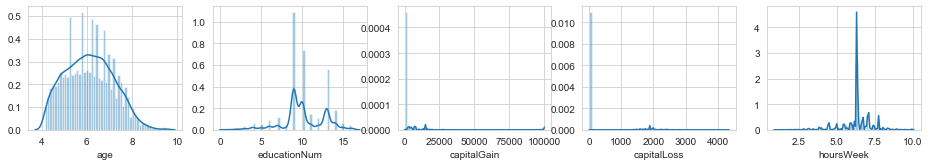

In [40]:
data_columns = df_train._get_numeric_data().columns.values
plot_columns = 7
number_of_columns = math.ceil(len(data_columns)/plot_columns)
number_of_rows = math.ceil((len(data_columns))/number_of_columns)

plt.figure(figsize=(16,5))

# plot distribution
for i in range(0, len(data_columns)):
    plt.subplot(number_of_columns + 1, number_of_rows, i+1)
    sns.distplot(df_train[data_columns[i]], kde=True) 

## Detect Outliers

Only numeric features can be fixed skew and outliers

### Box plots of the data

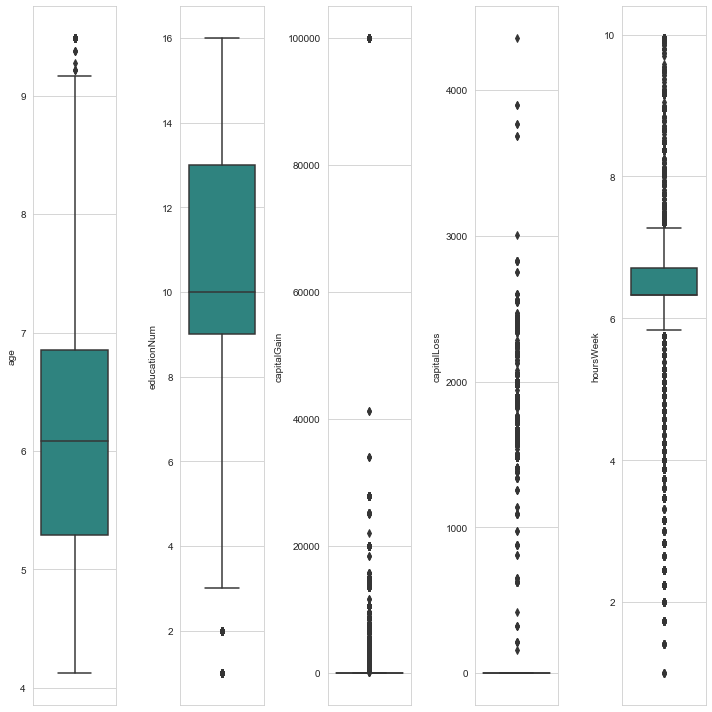

In [42]:
data_columns = df_train._get_numeric_data().columns.values
plot_columns = 7
number_of_columns = math.ceil(len(data_columns)/plot_columns)
number_of_rows = math.ceil((len(data_columns))/number_of_columns)

plt.figure(figsize=(10,10))
for i in range(0,len(data_columns)):
    plt.subplot(number_of_columns, number_of_rows, i+1)
    sns.set_style('whitegrid')
    sns.boxplot(df_train[data_columns[i]],palette='viridis',orient='v')
    plt.tight_layout()

In [41]:
outlier_cols = ['age', 'hoursWeek']

They need fixing:
The interquartile range (IQR)
Is a measure of variability, based on dividing a data set into quartiles.

Quartiles divide a rank-ordered data set into four equal parts. The values that divide each part are called the first, second, and third quartiles; and they are denoted by Q1, Q2, and Q3, respectively.

* Q1 is the "middle" value in the first half of the rank-ordered data set.
* Q2 is the median value in the set.
* Q3 is the "middle" value in the second half of the rank-ordered data set.

The interquartile range (IQR) is equal to Q3 minus Q1.

   * **upperbound** = IQR * 1.5 + Q3 
   * **lowerbound** = IQR * (-1.5) + Q1

If the data is higher than IQR*1.5 + Q3 or lower than the IQR * (-1.5) + Q1 it would be an outlier and we can replace it by the upper or lower bound.

In [43]:
for col in outlier_cols: 
    quartile_1, quartile_3 = np.percentile(df_train[col], [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    df_train[col] = np.where(df_train[col] > upper_bound, upper_bound, df_train[col])
    df_train[col] = np.where(df_train[col] < lower_bound, lower_bound, df_train[col])

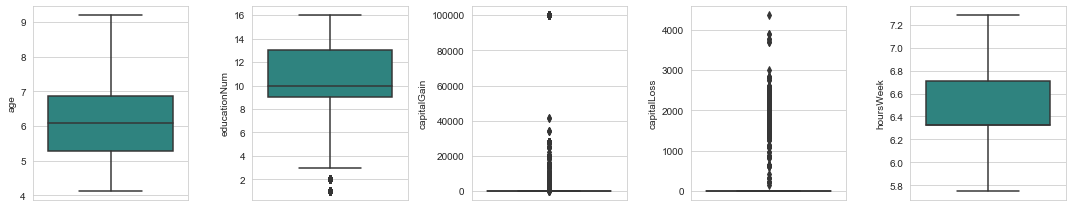

In [44]:
data_columns = df_train._get_numeric_data().columns.values
plot_columns = 7
number_of_columns = math.ceil(len(data_columns)/plot_columns)
number_of_rows = math.ceil((len(data_columns))/number_of_columns)

plt.figure(figsize=(15,3))
for i in range(0,len(data_columns)):
    plt.subplot(number_of_columns, number_of_rows, i+1)
    sns.set_style('whitegrid')
    sns.boxplot(df_train[data_columns[i]],palette='viridis',orient='v')
    plt.tight_layout()

## Convert categorical features<a class="anchor" id="convertion"></a>

If they are not numeric columns then we have to convert them into categorical features. If they can be 0 or 1, then we use LabelEncoder() otherwise, we create a column for each option and they will have a 0 or 1 type.
Note: education label == education-num los codigos corresponden, so we can drop "education column.

In [151]:
df_train = df_train.drop(['education'], axis=1)

In [152]:
df_train.select_dtypes(include=['object']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 8 columns):
workclass        30162 non-null object
maritalStatus    30162 non-null object
occupation       30162 non-null object
relationship     30162 non-null object
race             30162 non-null object
sex              30162 non-null object
nativeCountry    30162 non-null object
target           30162 non-null object
dtypes: object(8)
memory usage: 1.8+ MB


In [153]:
le_sex = LabelEncoder()
le_sex.fit(df_train.sex)
df_train['sex'] = le_sex.transform(df_train.sex)

le_target = LabelEncoder()
le_target.fit(df_train.target)
df_train['target'] = le_target.transform(df_train.target)

In [154]:
df_train.head()

,age,workclass,fnlwgt,educationNum,maritalStatus,occupation,relationship,race,sex,capitalGain,capitalLoss,hoursWeek,nativeCountry,target
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,1,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,1,0,0,13,United-States,0
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,1,0,0,40,United-States,0
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,1,0,0,40,United-States,0
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,0,0,0,40,Cuba,0


In [155]:
df_train.select_dtypes(include=['object']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 6 columns):
workclass        30162 non-null object
maritalStatus    30162 non-null object
occupation       30162 non-null object
relationship     30162 non-null object
race             30162 non-null object
nativeCountry    30162 non-null object
dtypes: object(6)
memory usage: 1.4+ MB


In [156]:
country = df_train['nativeCountry']
country.unique()

array([' United-States', ' Cuba', ' Jamaica', ' India', ' Mexico',
       ' Puerto-Rico', ' Honduras', ' England', ' Canada', ' Germany',
       ' Iran', ' Philippines', ' Poland', ' Columbia', ' Cambodia',
       ' Thailand', ' Ecuador', ' Laos', ' Taiwan', ' Haiti', ' Portugal',
       ' Dominican-Republic', ' El-Salvador', ' France', ' Guatemala',
       ' Italy', ' China', ' South', ' Japan', ' Yugoslavia', ' Peru',
       ' Outlying-US(Guam-USVI-etc)', ' Scotland', ' Trinadad&Tobago',
       ' Greece', ' Nicaragua', ' Vietnam', ' Hong', ' Ireland',
       ' Hungary', ' Holand-Netherlands'], dtype=object)

In [157]:
country.value_counts()

 United-States                 27504
 Mexico                          610
 Philippines                     188
 Germany                         128
 Puerto-Rico                     109
 Canada                          107
 El-Salvador                     100
 India                           100
 Cuba                             92
 England                          86
 Jamaica                          80
 South                            71
 Italy                            68
 China                            68
 Dominican-Republic               67
 Vietnam                          64
 Guatemala                        63
 Japan                            59
 Columbia                         56
 Poland                           56
 Iran                             42
 Taiwan                           42
 Haiti                            42
 Portugal                         34
 Nicaragua                        33
 Peru                             30
 Greece                           29
 

In [158]:
#df_train = df_train.drop(['fnlwgt'], axis=1)
df_no_country = df_train.drop(['nativeCountry'], axis=1)

### Workclass

In [71]:
df_train.describe(include='O')

,workclass,maritalStatus,occupation,relationship,race,nativeCountry
count,30162,30162,30162,30162,30162,30162
unique,7,7,14,6,5,41
top,Private,Married-civ-spouse,Prof-specialty,Husband,White,United-States
freq,22286,14065,4038,12463,25933,27504


In [159]:
df_train['workclass'].value_counts()

 Private             22286
 Self-emp-not-inc     2499
 Local-gov            2067
 State-gov            1279
 Self-emp-inc         1074
 Federal-gov           943
 Without-pay            14
Name: workclass, dtype: int64

In [170]:
col_n = 'workclass'
my_size = ' Without-pay'
df_no_volunteers = df_no_country.query("{0} != '{1}'".format(col_n, my_size))
#df_no_volunteers = df_train.query(f"{col_n } != '{my_size}'")
df_no_volunteers['workclass'].value_counts()

df_no_volunteers.isnull().sum()
#df_no_volunteers

age              0
workclass        0
educationNum     0
maritalStatus    0
occupation       0
relationship     0
race             0
sex              0
capitalGain      0
capitalLoss      0
hoursWeek        0
target           0
dtype: int64

In [161]:
workclass_dictionary = {
    " Private": "Private",
    " Self-emp-not-inc": "Self-employed",
    " Self-emp-inc": "Self-employed",
    " Federal-gov": "Government",
    " Local-gov": "Government",
    " State-gov" : "Government"
}

In [171]:
# a map of more aggregated title
# we map each title
df_no_volunteers['workclass'] = df_no_volunteers.workclass.map(workclass_dictionary)
df_no_volunteers.head()

df_no_volunteers.isnull().sum()

age              0
workclass        0
educationNum     0
maritalStatus    0
occupation       0
relationship     0
race             0
sex              0
capitalGain      0
capitalLoss      0
hoursWeek        0
target           0
dtype: int64

In [51]:
#df_train.head() #stays the same

In [172]:
df_workclass = pd.get_dummies(df_no_volunteers.workclass)
df_train_workclass = pd.concat([df_no_volunteers, df_workclass],axis=1)

#Erase title from df
df_train_workclass = df_train_workclass.drop(['workclass'], axis=1)
df_train_workclass.head()
df_train_workclass.isnull().sum()

age              0
educationNum     0
maritalStatus    0
occupation       0
relationship     0
race             0
sex              0
capitalGain      0
capitalLoss      0
hoursWeek        0
target           0
Government       0
Private          0
Self-employed    0
dtype: int64

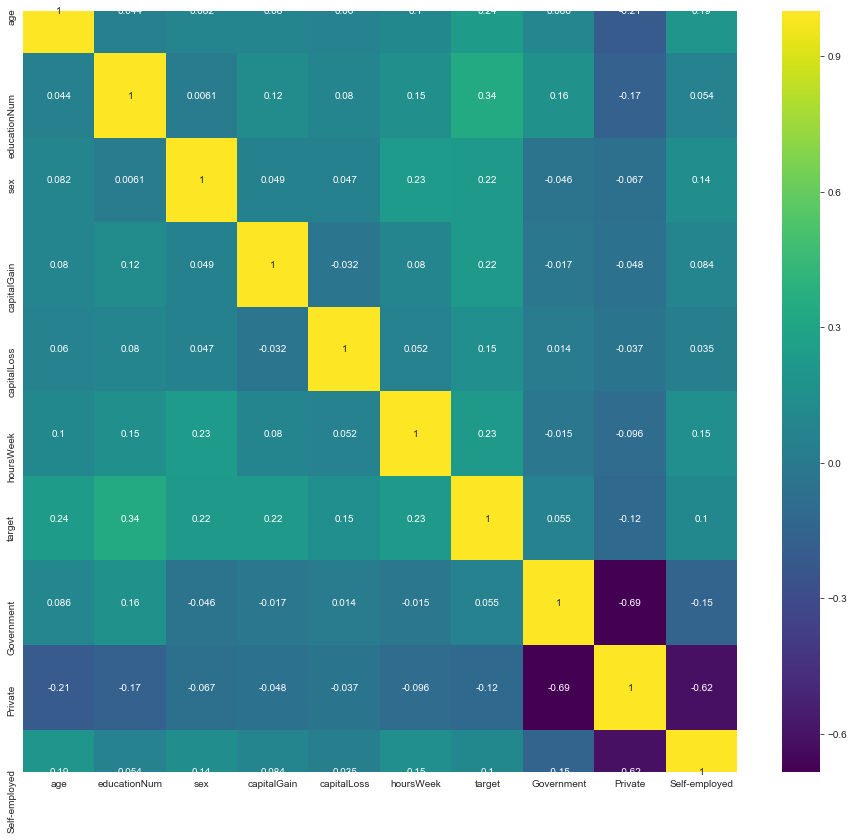

In [184]:
corr = df_train_workclass.corr()
#corr[np.abs(corr)<.4] = 0
plt.figure(figsize=(16,14))
sns.heatmap(corr, annot=True, cmap = 'viridis')

I'm goin to try to categorize them

In [ ]:
df_train_workclass

## maritalStatus

In [164]:
maritalStatus = df_train['maritalStatus']
maritalStatus.unique()

array([' Never-married', ' Married-civ-spouse', ' Divorced',
       ' Married-spouse-absent', ' Separated', ' Married-AF-spouse',
       ' Widowed'], dtype=object)

In [174]:
df_maritalStatus = pd.get_dummies(df_train_workclass.maritalStatus)
df_train_maritalStatus = pd.concat([df_train_workclass, df_maritalStatus],axis=1)

#Erase title from df
df_train_maritalStatus = df_train_maritalStatus.drop(['maritalStatus'], axis=1)
df_train_maritalStatus

df_train_maritalStatus.isnull().sum()

age                       0
educationNum              0
occupation                0
relationship              0
race                      0
sex                       0
capitalGain               0
capitalLoss               0
hoursWeek                 0
target                    0
Government                0
Private                   0
Self-employed             0
 Divorced                 0
 Married-AF-spouse        0
 Married-civ-spouse       0
 Married-spouse-absent    0
 Never-married            0
 Separated                0
 Widowed                  0
dtype: int64

## occupation       

In [122]:
df_train_maritalStatus['occupation'].value_counts()

 Prof-specialty       4038
 Craft-repair         4029
 Exec-managerial      3992
 Adm-clerical         3718
 Sales                3584
 Other-service        3211
 Machine-op-inspct    1965
 Transport-moving     1571
 Handlers-cleaners    1349
 Farming-fishing       983
 Tech-support          912
 Protective-serv       644
 Priv-house-serv       143
 Armed-Forces            9
Name: occupation, dtype: int64

In [175]:
df_occupation = pd.get_dummies(df_train_maritalStatus.occupation)
df_train_occupation = pd.concat([df_train_maritalStatus, df_occupation],axis=1)

#Erase title from df
df_train_occupation = df_train_occupation.drop(['occupation'], axis=1)
df_train_occupation

,age,educationNum,relationship,race,sex,capitalGain,capitalLoss,hoursWeek,target,Government,...,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving
0,39,13,Not-in-family,White,1,2174,0,40,0,1,...,0,0,0,0,0,0,0,0,0,0
1,50,13,Husband,White,1,0,0,13,0,0,...,0,0,0,0,0,0,0,0,0,0
2,38,9,Not-in-family,White,1,0,0,40,0,0,...,0,1,0,0,0,0,0,0,0,0
3,53,7,Husband,Black,1,0,0,40,0,0,...,0,1,0,0,0,0,0,0,0,0
4,28,13,Wife,Black,0,0,0,40,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30157,27,12,Wife,White,0,0,0,38,0,0,...,0,0,0,0,0,0,0,0,1,0
30158,40,9,Husband,White,1,0,0,40,1,0,...,0,0,1,0,0,0,0,0,0,0
30159,58,9,Unmarried,White,0,0,0,40,0,0,...,0,0,0,0,0,0,0,0,0,0
30160,22,9,Own-child,White,1,0,0,20,0,0,...,0,0,0,0,0,0,0,0,0,0


## race             

In [124]:
df_train_occupation['race'].value_counts()

 White                 25921
 Black                  2816
 Asian-Pac-Islander      894
 Amer-Indian-Eskimo      286
 Other                   231
Name: race, dtype: int64

In [176]:
df_race = pd.get_dummies(df_train_occupation.race)
df_train_race = pd.concat([df_train_occupation, df_race],axis=1)

#Erase title from df
df_train_race = df_train_race.drop(['race'], axis=1)
df_train_race

,age,educationNum,relationship,sex,capitalGain,capitalLoss,hoursWeek,target,Government,Private,...,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
0,39,13,Not-in-family,1,2174,0,40,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,50,13,Husband,1,0,0,13,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,38,9,Not-in-family,1,0,0,40,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,53,7,Husband,1,0,0,40,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,28,13,Wife,0,0,0,40,0,0,1,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30157,27,12,Wife,0,0,0,38,0,0,1,...,0,0,0,1,0,0,0,0,0,1
30158,40,9,Husband,1,0,0,40,1,0,1,...,0,0,0,0,0,0,0,0,0,1
30159,58,9,Unmarried,0,0,0,40,0,0,1,...,0,0,0,0,0,0,0,0,0,1
30160,22,9,Own-child,1,0,0,20,0,0,1,...,0,0,0,0,0,0,0,0,0,1


## relationship

In [127]:
df_train_race['relationship'].value_counts()

 Husband           12459
 Not-in-family      7726
 Own-child          4461
 Unmarried          3210
 Wife               1403
 Other-relative      889
Name: relationship, dtype: int64

In [177]:
df_relationship = pd.get_dummies(df_train_race.relationship)
df_train_relationship = pd.concat([df_train_race, df_relationship],axis=1)

#Erase title from df
df_train_relationship = df_train_relationship.drop(['relationship'], axis=1)
df_train_relationship

,age,educationNum,sex,capitalGain,capitalLoss,hoursWeek,target,Government,Private,Self-employed,...,Asian-Pac-Islander,Black,Other,White,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife
0,39,13,1,2174,0,40,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0
1,50,13,1,0,0,13,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
2,38,9,1,0,0,40,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
3,53,7,1,0,0,40,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
4,28,13,0,0,0,40,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30157,27,12,0,0,0,38,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
30158,40,9,1,0,0,40,1,0,1,0,...,0,0,0,1,1,0,0,0,0,0
30159,58,9,0,0,0,40,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
30160,22,9,1,0,0,20,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0


## Feature selection<a class="anchor" id="featureselection"></a>

For the feature selection part we are going to try different methods:
* Univariate analysis taking into account the chi squared statistical test.
* Feature importances of tree based classifiers
* Recursive feature elimination with logistic regression
* Feature selection with lasso method

The resampling protocol (training/test, cross-validation, etc) that you have used:

These are two ways to do cross validation: (podemos hacer una de ellas)

K-Folds Cross Validation

In [ ]:
from sklearn.model_selection import KFold # import KFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]]) # create an array
y = np.array([1, 2, 3, 4]) # Create another array
kf = KFold(n_splits=2) # Define the split - into 2 folds 
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
print(kf) 
KFold(n_splits=2, random_state=None, shuffle=False)

In [ ]:
for train_index, test_index in kf.split(X):
 print(“TRAIN:”, train_index, “TEST:”, test_index)
 X_train, X_test = X[train_index], X[test_index]
 y_train, y_test = y[train_index], y[test_index]
('TRAIN:', array([2, 3]), 'TEST:', array([0, 1]))
('TRAIN:', array([0, 1]), 'TEST:', array([2, 3]))

Leave One Out Cross Validation (LOOCV):
Lo que puedo hacer es 
1) solo enseñar que se puede hacer esto porque hara el split thel dataset y luego hacer lo del RandomizedSearchCV por ejemplo y usar su forma de hacer k-folds
2) en este mismo loop mientras hace el split tambien se hace la linea de:
    clf = RandomizedSearchCV(pipeline, hyperparameters, scoring='accuracy', random_state=1, n_iter=100, cv=5, verbose=0, n_jobs=-1)
 y esta tambien creo: clf.fit(X_train, y_train)
 
 y entonces se haria el split y luego esa linea se encargaria ya de usar ese split con la busqueda de parametros y los best etc.

Aconseja que solo enseñe y luego use lo de RAndomizedSEarch. 

Lo que no es: esta linea
clf.fit(X_train, y_train)

el X_Train, y train NO es la salida de este loop este NO es el cambio que deberia de hacer. 


In [ ]:
from sklearn.model_selection import LeaveOneOut 
X = np.array([[1, 2], [3, 4]])
y = np.array([1, 2])
loo = LeaveOneOut()
loo.get_n_splits(X)


for train_index, test_index in loo.split(X):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]
   print(X_train, X_test, y_train, y_test)

5. The results obtained using three linear/quadratic methods (indicating the best set of
parameters for each one):
(a) If the task is classification, any of: , multinomial regression (single-layer MLP), LDA, QDA, RDA, Naive Bayes, nearest-neighbours, linear SVM,
quadratic SVM

** k nearest-neighbours
** linear SVM (dijo que coger este y luego el que tiene el kerne de RBF nos daria una comparativa guay )
** logistic regression

6. The results obtained using two general non-linear methods (indicating the best set
of parameters for each one); for both classification and regression tasks, any of: the
MLP, the RBFNN, the SVM with RBF kernel, 

** the SVM with RBF kernel
** Random Forest

7. A description and justification of the final model chosen, and a honest estimation of its
generalization error

Posibles restricciones dentro del dataset: |   ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))